In [ ]:
%load_ext autoreload
%autoreload 2

In [24]:
import faiss
from loguru import logger
from hcmus.core import appconfig
from hcmus.lbs import LabelStudioConnector
from hcmus.data import LbsDataset

In [ ]:
torch_device = "cpu"
lsb_connector = LabelStudioConnector(
    url=appconfig.LABEL_STUDIO_URL,
    api_key=appconfig.LABEL_STUDIO_API_KEY,
    project_id=appconfig.LABEL_STUDIO_PROJECT_MAPPING["train"],
)
lsb_dataset = LbsDataset(lsb_connector, device=appconfig.TORCH_DEVICE, augmentation=False)
lsb_dataloader = lsb_dataset.get_dataloader()

In [10]:
image, target = lsb_dataset[0]
image_pil = lsb_dataset.tensor_to_image(image)

In [62]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def get_image_embedding(image: Image):
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = clip_model.get_image_features(**inputs)
    return outputs[0].cpu().numpy()

In [16]:
unknown_label = lsb_dataset._labels["unknown"]

In [13]:
embedding = get_image_embedding(image_pil)

In [ ]:
custom_dataset = []
for image_tensor, target in lsb_dataset:
    image = lsb_dataset.tensor_to_image(image_tensor)

    for label in target["labels"]:
        if label == unknown_label and len(target["labels"]) == 1:
            logger.warning("Image with only unknown label, skipped.")
            continue
        else:
            custom_dataset.append({
                "image": image,
                "label": label
            })

2025-04-13 20:07:42.052 | WARNING  | __main__:<module>:7 - Image with only unknown label, skipped.
2025-04-13 20:07:42.305 | WARNING  | __main__:<module>:7 - Image with only unknown label, skipped.
2025-04-13 20:07:42.773 | WARNING  | __main__:<module>:7 - Image with only unknown label, skipped.
2025-04-13 20:07:42.783 | WARNING  | __main__:<module>:7 - Image with only unknown label, skipped.


In [27]:
embeddings = []
for item in custom_dataset:
    image = item["image"]
    embeddings.append(get_image_embedding(image))

In [30]:
import numpy as np
embeddings_np = np.array(embeddings)

In [28]:
d = 512  # Dimensionality of CLIP embeddings
index = faiss.IndexFlatL2(d)  # L2 distance

In [31]:
index.add(embeddings_np)

In [57]:
def query_top_k(image: Image.Image, k=5):
    query_embedding = get_image_embedding(image).reshape(1, -1)
    distances, indices = index.search(query_embedding, k)
    return [(custom_dataset[i], distances[0][j]) for j, i in enumerate(indices[0])]

In [38]:
val_connector = LabelStudioConnector(
    url=appconfig.LABEL_STUDIO_URL,
    api_key=appconfig.LABEL_STUDIO_API_KEY,
    project_id=appconfig.LABEL_STUDIO_PROJECT_MAPPING["validation"],
)
val_dataset = LbsDataset(val_connector, device="cpu", augmentation=False)

Loading tasks:   1%|          | 1/100 [00:00<01:14,  1.34it/s]
2025-04-13 20:15:46.719 | INFO     | hcmus.data._lbs_dataset:__init__:33 - Number of labels: 16
2025-04-13 20:15:46.720 | INFO     | hcmus.data._lbs_dataset:__init__:34 - Number of data points: 7


In [37]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Use GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [48]:
def crop_sub_images(image, boxes):
    sub_images = []
    for box in boxes:
        box = [int(coord) for coord in box]
        sub_img = image.crop(box)
        sub_images.append(sub_img)
    return sub_images


In [53]:
image_tensor, target = val_dataset[1]

In [54]:
output = model([image_tensor])[0]
boxes = []
for box, score in zip(output["boxes"], output["scores"]):
    if score >= 0.1:
        boxes.append(box)

image_pil = val_dataset.tensor_to_image(image_tensor)
sub_images = crop_sub_images(image_pil, boxes)

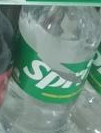

In [ ]:
for sub_image in sub_images:
    sub_emb = get_image_embedding(sub_image)

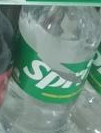

In [71]:
sub_images[2]

In [72]:
query_top_k(sub_images[2])

[({'image': <PIL.Image.Image image mode=RGB size=450x600>,
   'label': tensor(159, device='mps:0')},
  np.float32(40.888668)),
 ({'image': <PIL.Image.Image image mode=RGB size=450x600>,
   'label': tensor(159, device='mps:0')},
  np.float32(47.13685)),
 ({'image': <PIL.Image.Image image mode=RGB size=450x600>,
   'label': tensor(9, device='mps:0')},
  np.float32(48.131943)),
 ({'image': <PIL.Image.Image image mode=RGB size=450x600>,
   'label': tensor(100, device='mps:0')},
  np.float32(49.18991)),
 ({'image': <PIL.Image.Image image mode=RGB size=450x600>,
   'label': tensor(100, device='mps:0')},
  np.float32(49.18991))]

In [ ]:
idx_to_label = {v: k for k, v in lsb_dataset._labels.items()}

In [73]:
idx_to_label[159]

'8935049510604-nuoc-ngot-sprite-chai-320ml'

### Try the Model

In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
from matplotlib import pyplot as plt
from loguru import logger
from PIL import Image
from hcmus.core import appconfig
from hcmus.lbs import LabelStudioConnector
from hcmus.data import LbsDataset
from hcmus.models import kNNSearchModel, kNNSearchConfig
from hcmus.utils import viz_utils

torch_device = "cpu"
lsb_connector = LabelStudioConnector(
    url=appconfig.LABEL_STUDIO_URL,
    api_key=appconfig.LABEL_STUDIO_API_KEY,
    project_id=appconfig.LABEL_STUDIO_PROJECT_MAPPING["train"],
)
lsb_dataset = LbsDataset(lsb_connector, device=torch_device, augmentation=False)

Loading tasks:   4%|▍         | 4/100 [00:04<01:39,  1.03s/it]
2025-04-18 20:55:02.674 | INFO     | hcmus.data._lbs_dataset:__init__:33 - Number of labels: 210
2025-04-18 20:55:02.674 | INFO     | hcmus.data._lbs_dataset:__init__:34 - Number of data points: 1640


In [3]:
def process_images_labels():
    unknown_label_idx = lsb_dataset._labels["unknown"]
    idx_to_str = {v: k for k, v in lsb_dataset._labels.items()}
    merged_labels = []
    merged_images = []
    for tensor, target in lsb_dataset:
        for label in target["labels"]:
            if label == unknown_label_idx and len(target["labels"]) == 1:
                logger.warning("Image with only unknown label, skipped.")
                continue
            else:
                merged_labels.append(idx_to_str[int(label)])
                merged_images.append(lsb_dataset.tensor_to_image(tensor))
                break
    return merged_images, merged_labels

In [20]:
images, labels = process_images_labels()

2025-04-18 20:59:38.926 | WARNING  | __main__:process_images_labels:9 - Image with only unknown label, skipped.
2025-04-18 20:59:38.973 | WARNING  | __main__:process_images_labels:9 - Image with only unknown label, skipped.
2025-04-18 20:59:39.117 | WARNING  | __main__:process_images_labels:9 - Image with only unknown label, skipped.
2025-04-18 20:59:39.138 | WARNING  | __main__:process_images_labels:9 - Image with only unknown label, skipped.


In [67]:
model_config = kNNSearchConfig(
    images=images,
    labels=labels,
    box_threshold=0.4,
    label_threshold=65
)

In [68]:
search_model = kNNSearchModel(model_config)

/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Building index...: 100%|██████████| 1636/1636 [00:36<00:00, 44.74it/s]


In [48]:
import os
import random

def get_random_files(folder_path, sample_size=100, recursive=True):
    all_files = []

    if recursive:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                all_files.append(os.path.join(root, file))
    else:
        all_files = [
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if os.path.isfile(os.path.join(folder_path, f))
        ]

    sampled_files = random.sample(all_files, min(sample_size, len(all_files)))
    return sampled_files

In [52]:
distance_scores = []
for file_path in get_random_files("/Volumes/Cucumber/Projects/item-identification/local/shelves"):
    tmp = Image.open(file_path)
    result = search_model.predict(tmp)
    distance_scores.extend([x.metadata.get("distance_score") for x in result])

In [55]:
import numpy as np
import matplotlib.pyplot as plt
arr = np.array(distance_scores)

(array([   5.,   35.,  191.,  550., 1035.,  888.,  511.,  169.,   21.,
           2.]),
 array([ 16.58145523,  27.06567383,  37.54989624,  48.03411484,
         58.51833344,  69.00254822,  79.48677063,  89.97099304,
        100.45521545, 110.93943787, 121.42364502]),
 <BarContainer object of 10 artists>)

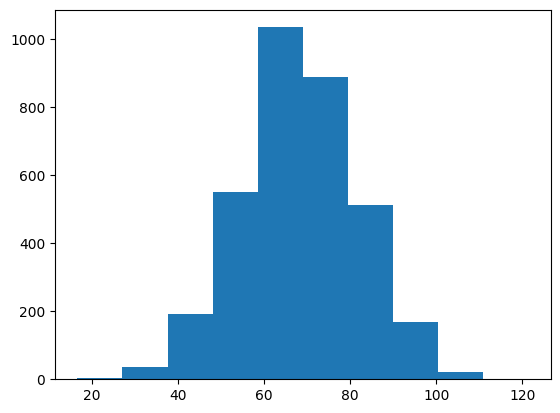

In [56]:
plt.hist(arr)

In [57]:
median = np.median(arr)
minimum = np.min(arr)
maximum = np.max(arr)
mean = np.mean(arr)

print("Median:", median)
print("Min:", minimum)
print("Max:", maximum)
print("Mean:", mean)

Median: 68.11177
Min: 16.581455
Max: 121.423645
Mean: 68.20679


In [64]:
search_model._config.label_threshold = 68
search_model._config.box_threshold = 0.4

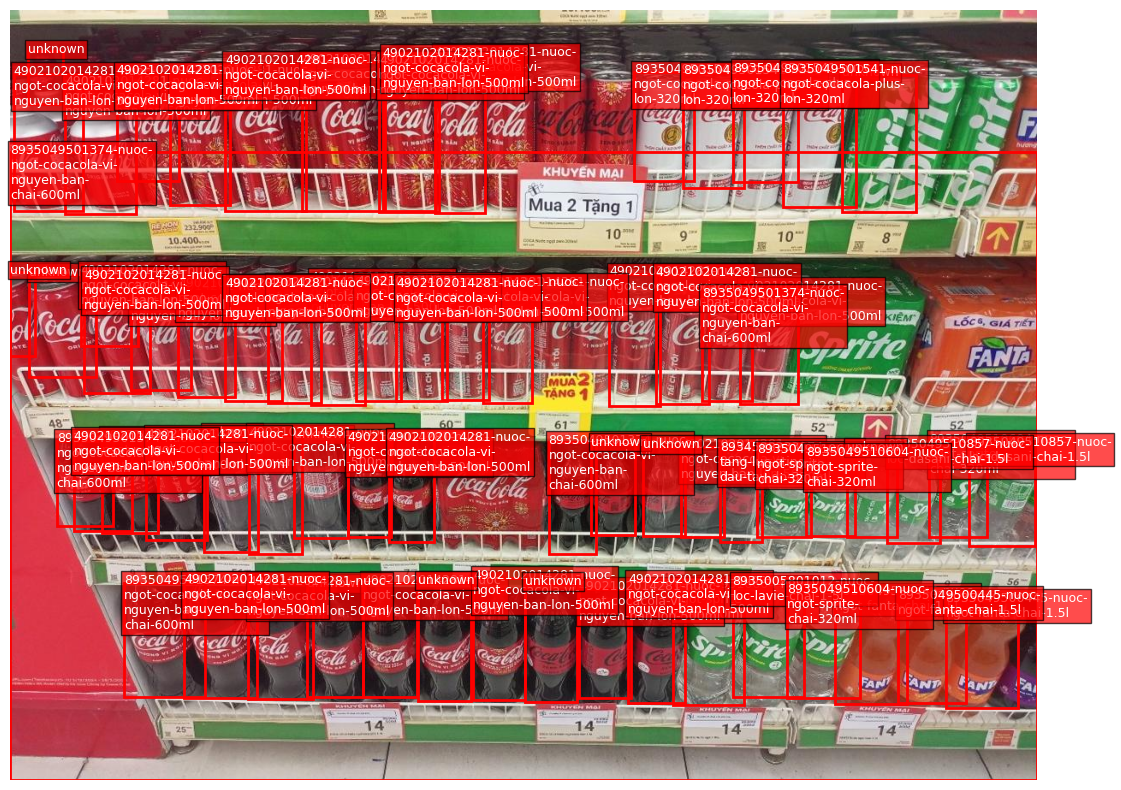

In [ ]:
tmp = Image.open()
# tmp = Image.open("/Volumes/Cucumber/Projects/item-identification/local/shelves/z6354739818372_6bdce7bc5e97f92f994f67f944c1c5f9.jpg")
tmp_result = search_model.predict(tmp)
tmp_boxes = [x.box for x in tmp_result]
tmp_labels = [x.label for x in tmp_result]
viz_utils.draw_boxes(tmp, tmp_boxes, tmp_labels)